## Configurations for Colab

In [1]:
"""
    在Ubuntu服务器上设置虚拟显示
    sudo apt update
    sudo apt install python-opengl ffmpeg xvfb
    启动虚拟X服务器
    Xvfb :1 -screen 0 1024x768x24 &
    export DISPLAY=:1
"""

from pyvirtualdisplay import Display

# Start virtual display
dis = Display(visible=0, size=(400, 400))
dis.start()

# 05. Noisy Networks for Exploration

[M. Fortunato et al., "Noisy Networks for Exploration." arXiv preprint arXiv:1706.10295, 2017.](https://arxiv.org/pdf/1706.10295.pdf)


NoisyNet is an exploration method that learns perturbations of the network weights to drive exploration. The key insight is that a single change to the weight vector can induce a consistent, and potentially very complex, state-dependent change in policy over multiple time steps.

Firstly, let's take a look into a linear layer of a neural network with $p$ inputs and $q$ outputs, represented by

$$
y = wx + b,
$$

where $x \in \mathbb{R}^p$ is the layer input, $w \in \mathbb{R}^{q \times p}$, and $b \in \mathbb{R}$ the bias.

The corresponding noisy linear layer is defined as:

$$
y = (\mu^w + \sigma^w \odot \epsilon^w) x + \mu^b + \sigma^b \odot \epsilon^b,
$$

where $\mu^w + \sigma^w \odot \epsilon^w$ and $\mu^b + \sigma^b \odot \epsilon^b$ replace $w$ and $b$ in the first linear layer equation. The parameters $\mu^w \in \mathbb{R}^{q \times p}, \mu^b \in \mathbb{R}^q, \sigma^w \in \mathbb{R}^{q \times p}$ and $\sigma^b \in \mathbb{R}^q$ are learnable, whereas $\epsilon^w \in \mathbb{R}^{q \times p}$ and $\epsilon^b \in \mathbb{R}^q$ are noise random variables which can be generated by one of the following two ways:

1. **Independent Gaussian noise**: the noise applied to each weight and bias is independent, where each random noise entry is drawn from a unit Gaussian distribution. This means that for each noisy linear layer, there are $pq + q$ noise variables (for $p$ inputs to the layer and $q$ outputs).
2. **Factorised Gaussian noise:** This is a more computationally efficient way. It produces 2 random Gaussian noise vectors ($p, q$) and makes $pq + q$ noise entries by outer product as follows:

$$
\begin{align}
\epsilon_{i,j}^w &= f(\epsilon_i) f(\epsilon_j),\\
\epsilon_{j}^b &= f(\epsilon_i),\\
\text{where } f(x) &= sgn(x) \sqrt{|x|}.
\end{align}
$$

In all experiements of the paper, the authors used Factorised Gaussian noise, so we will go for it as well.

In [2]:
import math
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import mindspore
from mindspore import nn, ops, Tensor, Parameter
from mindnlp.modules import Accumulator
from IPython.display import clear_output
from mindspore.common import dtype as mstype

[WARNING] ME(428022:140550970492736,MainProcess):2023-07-07-08:47:01.431.652 [mindspore/run_check/_check_version.py:102] MindSpore version 2.0.0.20230623 and cuda version 11.7.60 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.
/home/daiyuxin/anaconda3/envs/cjh1/lib/python3.7/site-packages/mindnlp/utils/download.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Noisy Layer

**References:**
- https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb
- https://github.com/Kaixhin/Rainbow/blob/master/model.py

In [19]:
class NoisyDense(nn.Cell):
    """Noisy linear module for NoisyNet.

    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyDense, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        mu_range = 1 / math.sqrt(self.in_features)

        self.weight_mu = Parameter(Tensor(ops.uniform((self.out_features, self.in_features), Tensor(-mu_range, mindspore.float32), Tensor(mu_range, mindspore.float32)), mstype.float32), name="weight_mu")
        self.weight_sigma = Parameter(
            Tensor(np.full((self.out_features, self.in_features), self.std_init / math.sqrt(self.in_features)), mstype.float32), name="weight_sigma"
        )
        self.weight_epsilon = Parameter(Tensor(np.empty((out_features, in_features)), mstype.float32), name="weight_epsilon", requires_grad=False)

        self.bias_mu = Parameter(Tensor(ops.uniform((self.out_features,), Tensor(-mu_range, mindspore.float32), Tensor(mu_range, mindspore.float32)), mstype.float32), name="bias_mu")
        self.bias_sigma = Parameter(Tensor(np.full((self.out_features,), self.std_init / math.sqrt(self.out_features)), mstype.float32), name="bias_sigma")
        self.bias_epsilon = Parameter(Tensor(np.empty(out_features), mstype.float32), name="bias_epsilon", requires_grad=False)

        self.reset_noise()

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.set_data((epsilon_out.ger(epsilon_in)).copy())
        self.bias_epsilon.set_data(epsilon_out.copy())

    def construct(self, x: Tensor) -> Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return ops.dense(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = ops.randn(size)

        return x.sign().mul(x.abs().sqrt())

## Noisy Network

We use NoisyLinear for the last two FC layers, and there is a method to reset noise at every step.
These are the only differences from the example of *01.dqn.ipynb*.

In [20]:
class Network(nn.Cell):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.feature = nn.Dense(in_dim, 128)
        self.noisy_layer1 = NoisyDense(128, 128)
        self.noisy_layer2 = NoisyDense(128, out_dim)

    def construct(self, x: Tensor) -> Tensor:
        """Forward method implementation."""
        feature = ops.relu(self.feature(x))
        hidden = ops.relu(self.noisy_layer1(feature))
        out = self.noisy_layer2(hidden)

        return out

    def reset_noise(self):
        """Reset all noisy layers."""
        self.noisy_layer1.reset_noise()
        self.noisy_layer2.reset_noise()

## DQN + NoisyNet Agent (w/o DuelingNet)

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

In the paper, NoisyNet is used as a component of the Dueling Network Architecture, which includes Double-DQN and Prioritized Experience Replay. However, we don't implement them to simplify the tutorial. One thing to note is that NoisyNet is an alternertive to $\epsilon$-greedy method, so all $\epsilon$ related lines are removed. Please check all comments with *NoisyNet*.

In [21]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            gamma (float): discount factor
        """
        # NoisyNet: All attributes related to epsilon are removed
        obs_dim = env.observation_space.shape[0]
        action_dim = int(env.action_space.n)

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma

        # device: cpu / gpu
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        mindspore.set_context(device_target='GPU')
        self.device = 'GPU'
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim)
        self.dqn_target = Network(obs_dim, action_dim)
        mindspore.load_param_into_net(self.dqn_target, self.dqn.parameters_dict())
        self.dqn.set_train(True)
        self.dqn_target.set_train(False)

        # optimizer
        self.accumulate_step = 2
        self.optimizer = nn.Adam(self.dqn.trainable_params())
        self.accumulator = Accumulator(self.optimizer, self.accumulate_step)

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

        # Get gradient function
        self.grad_fn = mindspore.value_and_grad(self.forward_fn, None, self.dqn.trainable_params())

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            Tensor(state, mindspore.float32).expand_dims(0)
        ).argmax()
        selected_action = selected_action.asnumpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def forward_fn(self):
        """Forward function"""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        return loss / self.accumulate_step

    def train_step(self) -> Tensor:
        """Training steps"""
        loss, grads = self.grad_fn()
        loss = ops.depend(loss, self.accumulator(grads))
        return loss

    def update_model(self) -> Tensor:
        """Update the model by gradient descent."""
        loss = self.train_step()

        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item(0) * self.accumulate_step

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # NoisyNet: removed decrease of epsilon

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True

        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> Tensor:
        """Return dqn loss."""
        state = Tensor(samples["obs"], mindspore.float32)
        next_state = Tensor(samples["next_obs"], mindspore.float32)
        action = Tensor(samples["acts"].reshape(-1, 1), mindspore.int64)
        reward = Tensor(samples["rews"].reshape(-1, 1), mindspore.float32)
        done = Tensor(samples["done"].reshape(-1, 1), mindspore.float32)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather_elements(1, action)
        next_q_value = self.dqn_target(next_state).max(
            axis=1, keepdims=True, return_indices=True
        )[0]
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask)

        # calculate dqn loss
        loss = ops.smooth_l1_loss(curr_q_value, target, reduction="mean")

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        mindspore.load_param_into_net(self.dqn_target, self.dqn.parameters_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [22]:
# environment
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

## Set random seed

In [23]:
seed = 777


def seed_mindspore(seed):
    """Set Random Seed"""
    mindspore.set_seed(seed)


np.random.seed(seed)
seed_mindspore(seed)

## Initialize

In [24]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 256
target_update = 150

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, seed)

GPU


## Train

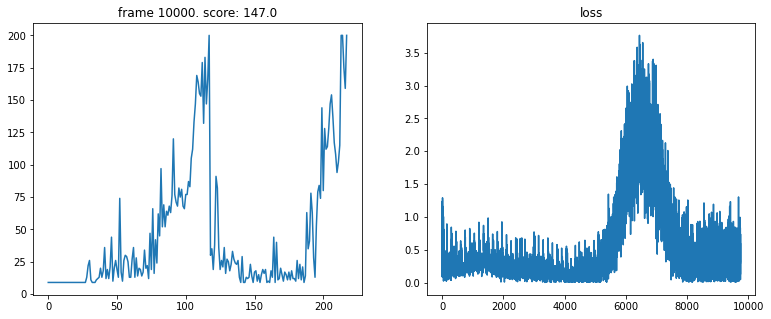

In [25]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [26]:
video_folder = "videos/noisy_net"
agent.test(video_folder=video_folder)

/home/daiyuxin/anaconda3/envs/cjh1/lib/python3.7/site-packages/gymnasium/wrappers/record_video.py:88: UserWarning: WARN: Overwriting existing videos at /data1/cjh1/rainbow-is-all-you-need-MindSpore/videos/noisy_net folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


Moviepy - Building video /data1/cjh1/rainbow-is-all-you-need-MindSpore/videos/noisy_net/rl-video-episode-0.mp4.
Moviepy - Writing video /data1/cjh1/rainbow-is-all-you-need-MindSpore/videos/noisy_net/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /data1/cjh1/rainbow-is-all-you-need-MindSpore/videos/noisy_net/rl-video-episode-0.mp4
score:  200.0


## Render

In [27]:
import base64
import glob
import io

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/noisy_net/rl-video-episode-0.mp4
